In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import ScrapeNBAData

# Compare 3pt shooting percentage, attempts vs wins for each team

In [57]:
#new names for shooting df, Valid up to 2016
newShootingColumnNames = [
    'Rk',
    'Team',
    'G',
    'MP',
    'FG%',
    'Dist',
    'Toss',
    '% of FGA by dist:2p',
    '% of FGA by dist:0-3',
    '% of FGA by dist:3-10',
    '% of FGA by dist:10-16',
    '% of FGA by dist:16-3P',
    '% of FGA by dist:3P',
    'Toss',
    'FG% by dist:2p',
    'FG% by dist:0-3',
    'FG% by dist:3-10',
    'FG% by dist:10-16',
    'FG% by dist:16-3P',
    'FG% by dist:3P',
    'Toss',
    '% of FG Assisted:2P',
    '% of FG Assisted:3P',
    'Toss',
    'Dunks:%FGA',
    'Dunks:Made',
    'Toss',
    'Layups:%FGA',
    'Layups:Made',
    'Toss',
    'Corner:%3PA',
    'Corner:3P%',
    'Toss',
    'Heaves:Att',
    'Heaves:Made',
    'Year'
    ]

In [256]:
teamData = []
for idx, season in enumerate(range(2002,2025)):
    teamData.append(ScrapeNBAData.getTeamData(season))
    print(season)
    for df in range(len(teamData[idx])):
        teamData[idx][df]['Year'] =  ([season]*len(teamData[idx][df]))

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [257]:
# Collect data and clean it
seasons_list = []

for season in range(len(teamData)):
    # Get standings, wins, and losses, 
    # Need to combine eastern and western conference standings
    teamData[season][1].columns = teamData[season][0].columns
    df_standings = pd.concat([teamData[season][0], teamData[season][1]])
    df_standings = df_standings[df_standings['W'].astype(str).str.contains('Division') == False]
    df_standings = df_standings.rename(columns={'Eastern Conference':'Team'})
    df_standings = df_standings.sort_values(by=['Team'])
    df_standings = df_standings.reset_index(drop = True)
    df_standings = df_standings.dropna()

    ## Get team stats and concat all data frames, remove duplicates 
    ## For year == 2001:2015 
        #Team it is df[][4]; for year == 2016: it is df[][6]
        #Shooting it is df[][9]; for year == 2016: it is df[][11]
    if teamData[season][9]['Year'][0] < 2016:
        team = 4
        shooting = 9
    else:
        team = 6
        shooting = 11

    #Team totals
    teamData[season][team] = teamData[season][team].sort_values(by=['Team'])
    teamData[season][team] = teamData[season][team].reset_index(drop=True)

    # Team shooting stats
    teamData[season][shooting] = teamData[season][shooting].set_axis(newShootingColumnNames, axis =1)
    teamData[season][shooting] = teamData[season][shooting].loc[:,~teamData[season][shooting].columns.duplicated()].copy()
    teamData[season][shooting] = teamData[season][shooting].drop('Toss', axis = 1)
    teamData[season][shooting] = teamData[season][shooting].reset_index(drop=True)
    teamData[season][shooting] = teamData[season][shooting].dropna()

    df_team = pd.concat([df_standings, teamData[season][team], teamData[season][shooting]], axis = 1)
    df_team = df_team.loc[:,~df_team.columns.duplicated()].copy()

    # Change data types for correlation matrix
    for metric in ['W', 'L', 'W/L%', 'PS/G', 'PA/G', 'SRS']:
        df_team[metric] = pd.to_numeric(df_team[metric])

    df_team['Corner:3PMd'] = df_team['Corner:3P%'] * df_team['3PA'] * df_team['Corner:%3PA']
    print(teamData[season][9]['Year'][0])
    seasons_list.append(df_team)

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [259]:
seasons_list[19].columns

Index(['Team', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS', 'Year', 'Rk',
       'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Dist', '% of FGA by dist:2p', '% of FGA by dist:0-3',
       '% of FGA by dist:3-10', '% of FGA by dist:10-16',
       '% of FGA by dist:16-3P', '% of FGA by dist:3P', 'FG% by dist:2p',
       'FG% by dist:0-3', 'FG% by dist:3-10', 'FG% by dist:10-16',
       'FG% by dist:16-3P', 'FG% by dist:3P', '% of FG Assisted:2P',
       '% of FG Assisted:3P', 'Dunks:%FGA', 'Dunks:Made', 'Layups:%FGA',
       'Layups:Made', 'Corner:%3PA', 'Corner:3P%', 'Heaves:Att', 'Heaves:Made',
       'Corner:3PMd'],
      dtype='object')

# Look at pd.corr or other ways to measure/plot correlations.  Maybe a table of correlation for each variable.
Then compare to modern

In [280]:
x_years = []
y_3PA, y_perct_of_0_3, y_perct_of_3_10, y_perct_of_10_16, y_perct_of_16_3P, y_perct_of_3P, y_pts, dist, pts, fga_g, y_corner3att_g  = [],[], [], [], [], [], [], [], [], [], []
y_corner_3PMd_g, y_Corr_W_3att, y_Corr_W_3md, y_Corr_W_pts, y_Corr_W_3PA = [], [], [], [], []
for season in range(len(seasons_list)):
    x_years.append(seasons_list[season].Year[0])

for season in range(len(seasons_list)):
    y_3PA.append(seasons_list[season]['3PA'].mean()/ seasons_list[season]['G'].mean())
    y_Corr_W_pts.append(seasons_list[season]['W'].corr(seasons_list[season]['PTS']))
    y_Corr_W_3PA.append(seasons_list[season]['W'].corr(seasons_list[season]['3PA']))
    y_Corr_W_3att.append(seasons_list[season]['W'].corr(seasons_list[season]['Corner:%3PA']))
    y_Corr_W_3md.append(seasons_list[season]['W'].corr(seasons_list[season]['Corner:3PMd']))
    y_perct_of_0_3.append(seasons_list[season]['% of FGA by dist:0-3'].mean())
    y_perct_of_3_10.append(seasons_list[season]['% of FGA by dist:3-10'].mean()) 
    y_perct_of_10_16.append(seasons_list[season]['% of FGA by dist:10-16'].mean())
    y_perct_of_16_3P.append(seasons_list[season]['% of FGA by dist:16-3P'].mean())
    y_perct_of_3P.append(seasons_list[season]['% of FGA by dist:3P'].mean())
    y_pts.append(seasons_list[season]['W'].corr(seasons_list[season]['3P%'])) 
    fga_g.append(seasons_list[season]['FGA'].mean()/ seasons_list[season]['G'].mean())
    dist.append(seasons_list[season]['Dist'].mean())
    pts.append(seasons_list[season]['PTS'].mean()/ seasons_list[season]['G'].mean())
    y_corner3att_g.append(seasons_list[season]['Corner:%3PA'].mean() * seasons_list[season]['3PA'].mean() / seasons_list[season]['G'].mean())
    y_corner_3PMd_g.append(seasons_list[season]['Corner:3PMd'].mean()/ seasons_list[season]['G'].mean())
    


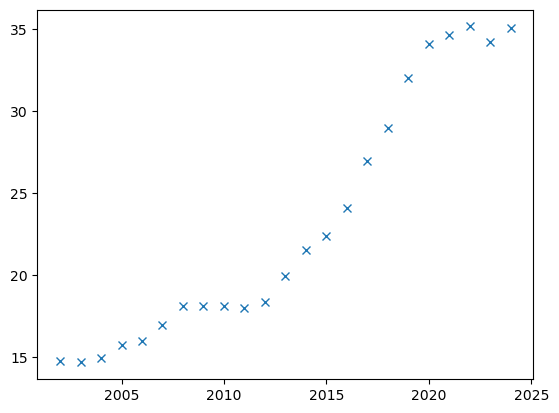

Text(0.5, 1.0, 'Avg points scored by a team')

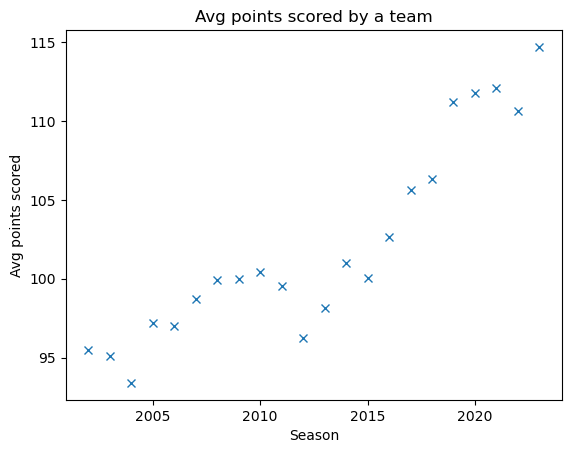

In [210]:
plt.figure()
plt.plot(x_years, pts, 'x')
plt.xlabel('Season')
plt.ylabel('Avg points scored')
plt.title('Avg points scored by a team')

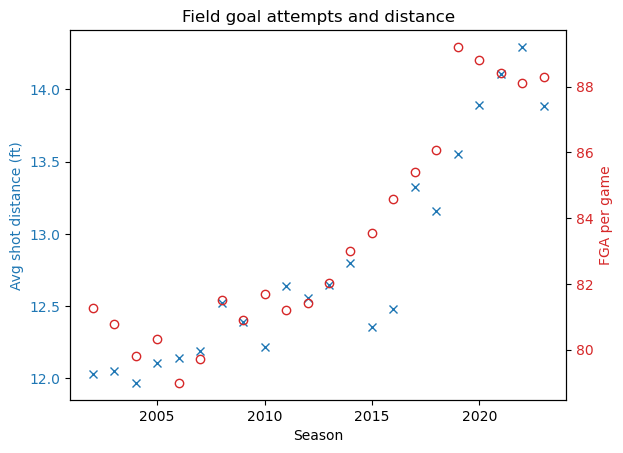

In [205]:
fig, ax1 = plt.subplots()
#plt.plot(x_years, y_3PA)
#plt.plot(x_years, y_Corner3Pper)
color = 'tab:blue'
ax1.plot(x_years, dist, 'x', color = color)
ax1.set_ylabel('Avg shot distance (ft)', color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.set_xlabel('Season')
ax1.set_title('Field goal attempts and distance')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(x_years, fga_g, 'o', fillstyle= 'none', color = color)
ax2.set_ylabel('FGA per game', color = color)
ax2.tick_params(labelcolor = color)

plt.show()

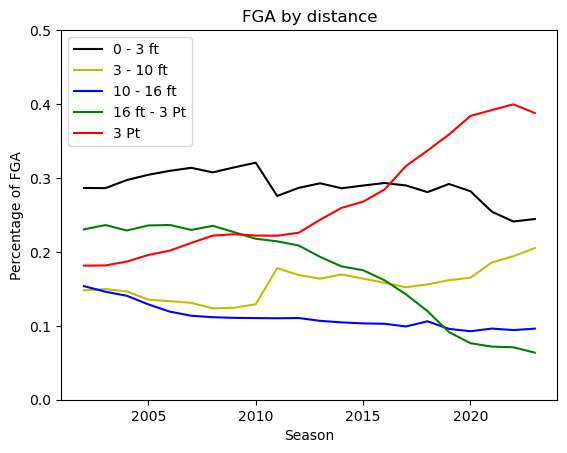

In [175]:
plt.figure()
plt.plot(x_years, y_perct_of_0_3, 'k', label = '0 - 3 ft')
plt.plot(x_years, y_perct_of_3_10, 'y', label = '3 - 10 ft')
plt.plot(x_years, y_perct_of_10_16, 'b', label = '10 - 16 ft')
plt.plot(x_years, y_perct_of_16_3P, 'g', label = '16 ft - 3 Pt')
plt.plot(x_years, y_perct_of_3P, 'r', label = '3 Pt')

plt.ylim(0, .5)
plt.legend()
plt.title("FGA by distance")
plt.ylabel("Percentage of FGA")
plt.xlabel("Season")
plt.show()

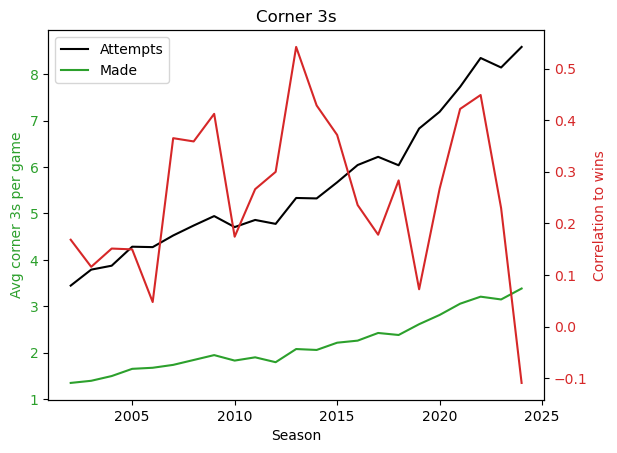

In [272]:
fig, ax = plt.subplots()

color = 'tab:green'
ax.set_title('Corner 3s')
ax.set_xlabel("Season")
ax.plot(x_years, y_corner3att_g, color = 'k', label = 'Attempts')
ax.plot(x_years, y_corner_3PMd_g, color = color, label = 'Made')
ax.set_ylabel('Avg corner 3s per game', color = color)
ax.tick_params(axis = 'y', labelcolor = color)

color = 'tab:red'
ax2 = ax.twinx()
ax2.plot(x_years,y_Corr_W_3att, color = color)
ax2.set_ylabel('Correlation to wins', color = color)
ax2.tick_params(labelcolor = color)

ax.legend()


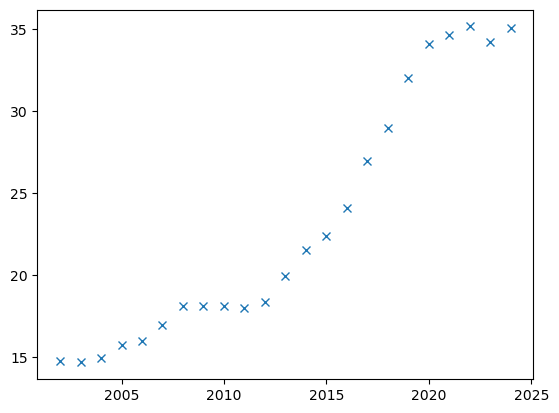

In [284]:
plt.plot(x_years, y_3PA, 'x')

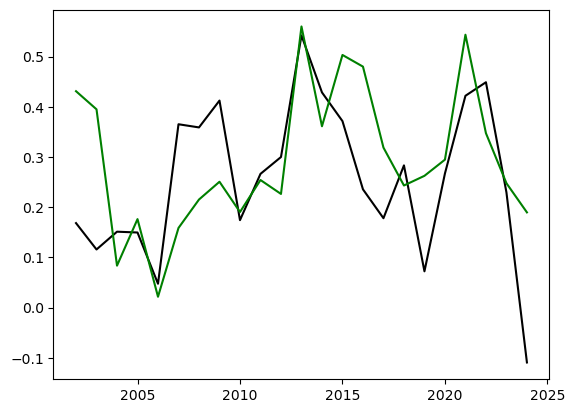

In [270]:
plt.plot(x_years, y_Corr_W_3att, color = 'k')
plt.plot(x_years, y_Corr_W_3md , color= 'g')

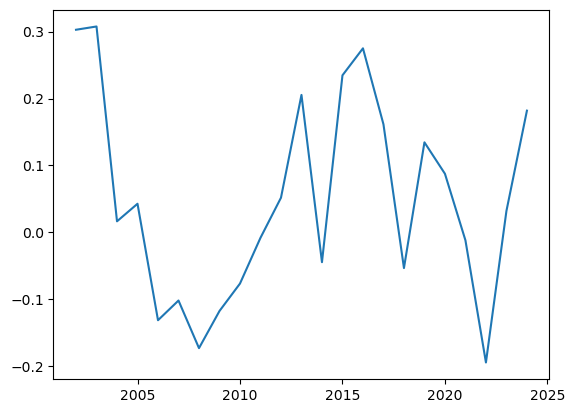

In [282]:
plt.plot(x_years, y_Corr_W_3PA)

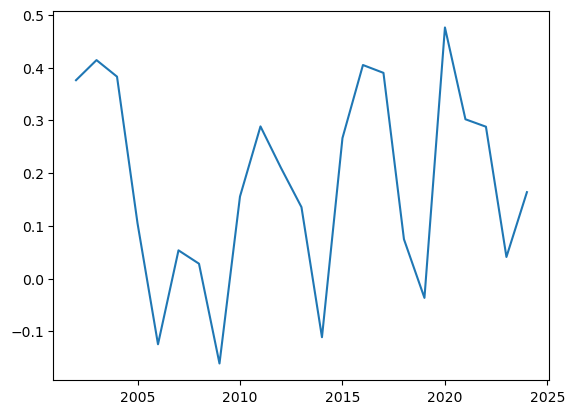

In [283]:
plt.plot(x_years, y_Corr_W_pts)

In [ ]:
## Basketball reference slug
lbj = "jamesle01"
jokic = "jokicni01"
curry = 'curryst01'

In [ ]:
james2011 = ScrapeNBAData.plotIndividualShotChart(lbj, 2011)
james2023 = ScrapeNBAData.plotIndividualShotChart(lbj, 2023)
curry2010 = ScrapeNBAData.plotIndividualShotChart(curry, 2011)
curry2023 = ScrapeNBAData.plotIndividualShotChart(curry, 2023)
jokic2015 = ScrapeNBAData.plotIndividualShotChart(jokic, 2016)
jokic2023 = ScrapeNBAData.plotIndividualShotChart(jokic, 2023)